In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from analysis import collection, analysis, emg
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'axes.labelsize': 16})

image_path = Path("/Users/spencer/phd/phd/images/")

### block cov

(2000, 2000) (64,) (64, 64)


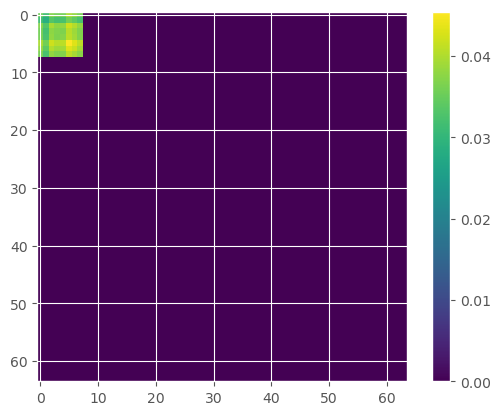

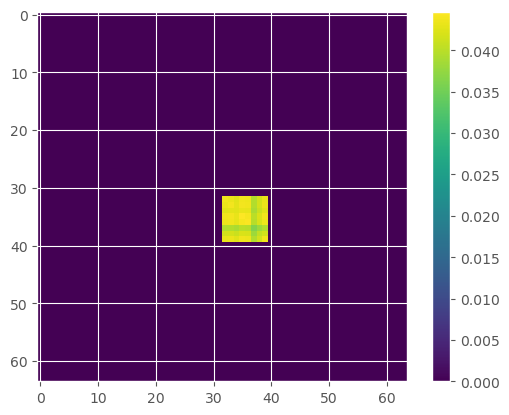

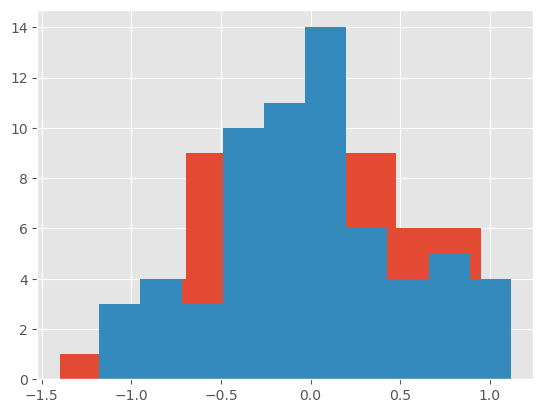

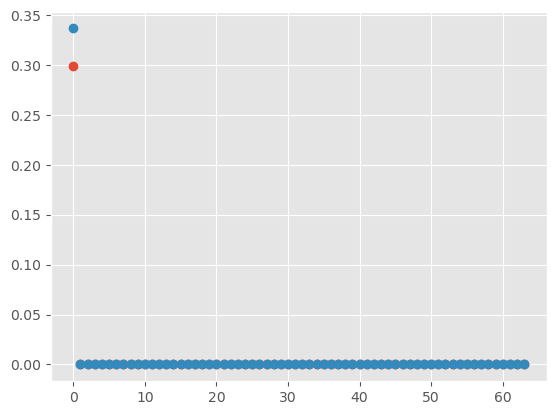

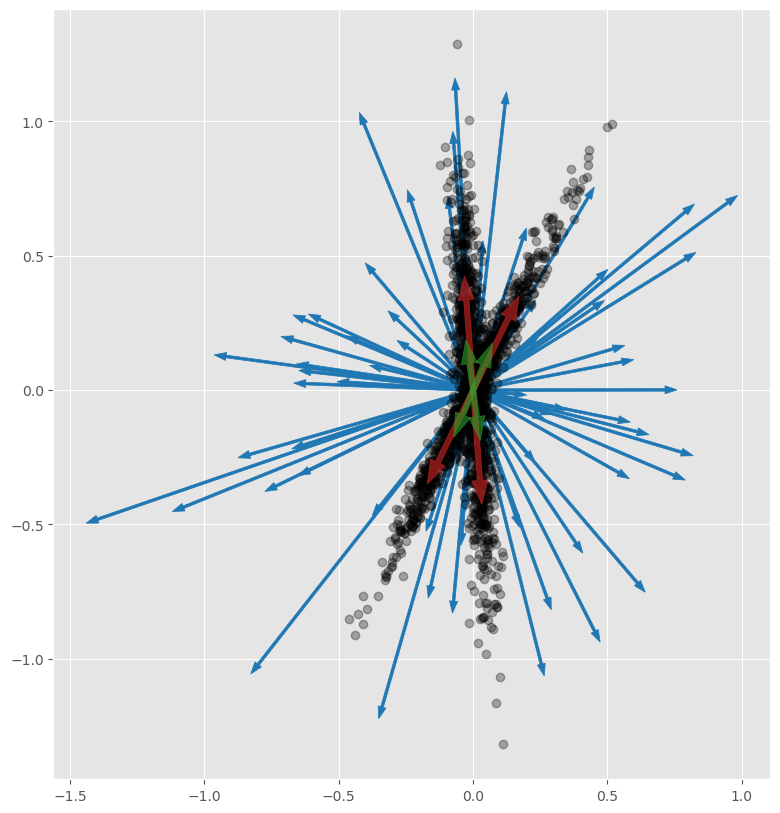

In [2]:
off_diag_sigma = 0.2
diag_multiple = 0.01
block_starts = [0, 32]
block_width = 8
Xs = []
means = []
# number of covariances
for start in block_starts:
    x = np.zeros(64)
    x[start:start+block_width] = np.random.normal(off_diag_sigma,0.01,size=(block_width))
    # rank-1 matrix
    X = np.outer(x,x)
    # grab the nonzero block
    block = X[start:start+block_width,start:start+block_width] 
    # replace that variance with amplified version
    block += np.diag(np.diag(block))*diag_multiple
    X[start:start+block_width,start:start+block_width] = block
    m = np.zeros(64) # + np.random.normal(0,0.1,size=(64))
    means.append(m)
    plt.figure()
    plt.imshow(X)
    plt.colorbar()
    Xs.append(X)

# define a GMM model based on the covariances above
weights = [1/len(Xs)] * len(Xs)
gmm = GaussianMixture(n_components=len(Xs))
gmm.weights_ = np.array(weights)
gmm.means_ = np.array(means)
gmm.covariances_ = np.array(Xs)
test_decoder = np.random.normal(0,0.5,(2,64))
plt.figure()
plt.hist(test_decoder[0])
plt.hist(test_decoder[1])

top_components = []
singular_vals = []
plt.figure()
for X in Xs: 
    U, S, V = np.linalg.svd(X)
    top_components.append(U[:,0])
    singular_vals.append(S[0])
    plt.plot(S,"o")

plt.figure(figsize=(10,10))
# sample data, project onto decoder, and plot samples
samples, components = gmm.sample(2000)
traj = test_decoder @ samples.T
plt.plot(traj[0],traj[1],"ko",alpha=0.3)
# plot covariance eigenvectors, through the decoder
for direction in test_decoder.T:
    plt.arrow(0,0,direction[0],direction[1],color="tab:blue",width=0.01)
for sv, component in zip(singular_vals,top_components):
    evec = test_decoder @ component
    # normalize evec
    evec /= np.linalg.norm(evec)
    # scale by singular value -- really want to scale by variance?
    evec *= sv         
    plt.arrow(0,0,evec[0],evec[1],color="tab:red",width=0.02,zorder=100,alpha=0.6)
    plt.arrow(0,0,-evec[0],-evec[1],color="tab:red",width=0.02,zorder=100,alpha=0.6)
# plt.ylim([-2,2])
# plt.xlim([-2,2])
plt.gca().set_aspect("equal")

# Do PCA on the sampled data!
mean_zero = samples - samples.mean(axis=0)
Us, Ss, Vs = np.linalg.svd(mean_zero)
print(Us.shape, Ss.shape, Vs.shape)
for i in range(2):
    evec = test_decoder @ Vs[i].T
    sv = Ss[i]
    # normalize evec
    evec /= np.linalg.norm(evec)
    # scale by singular value -- really want to scale by variance?
    evec *= .1
    plt.arrow(0,0,evec[0],evec[1],color="tab:green",width=0.02,zorder=100,alpha=0.6)
    plt.arrow(0,0,-evec[0],-evec[1],color="tab:green",width=0.02,zorder=100,alpha=0.6)

#### Confirm that the matrix is rank 2, that the eigenvectors are the original rank-1 matrices

#### If the original matrices overlap, we can't recover the original matrices!

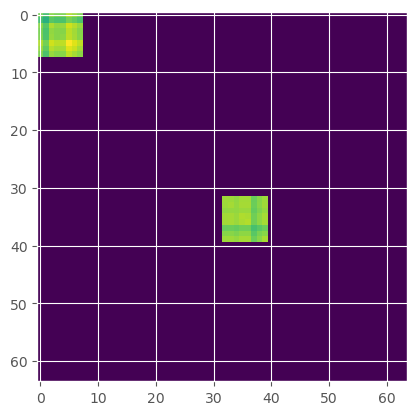

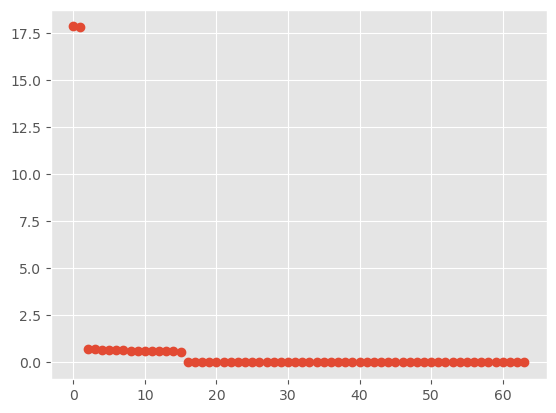

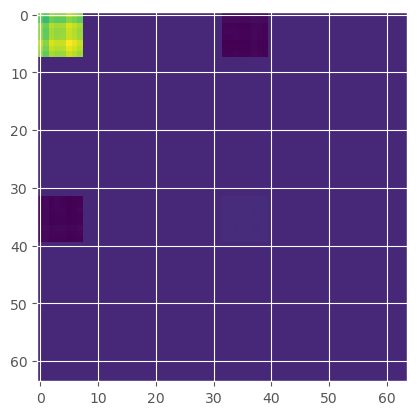

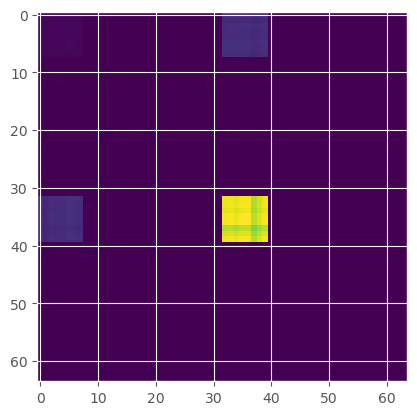

In [3]:
C = np.cov(samples.T)
plt.figure()
plt.imshow(C)
U,S,V = np.linalg.svd(C)

plt.figure()
plt.plot(Ss,"o")

for i in range(2):
    plt.figure()
    plt.imshow(np.outer(V[i],V[i].T))

(64, 64)
(1000, 64)


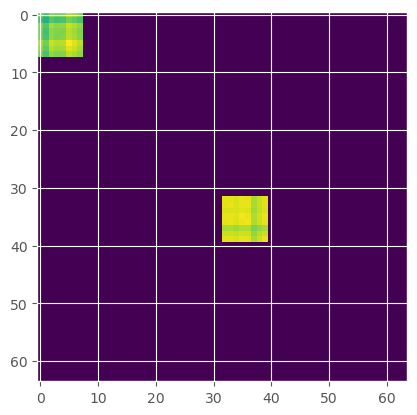

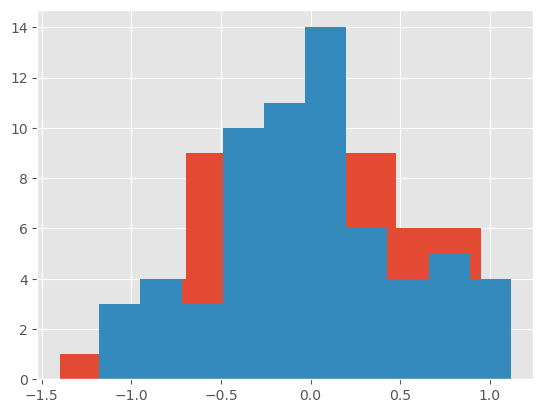

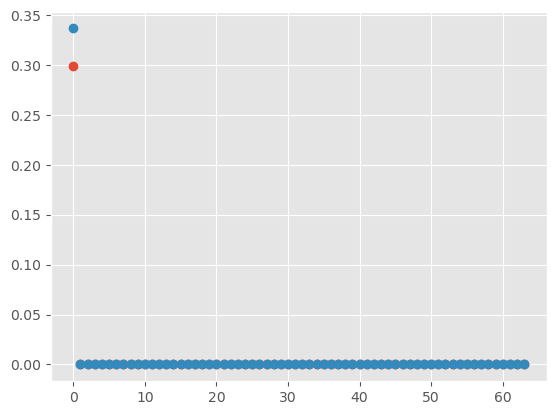

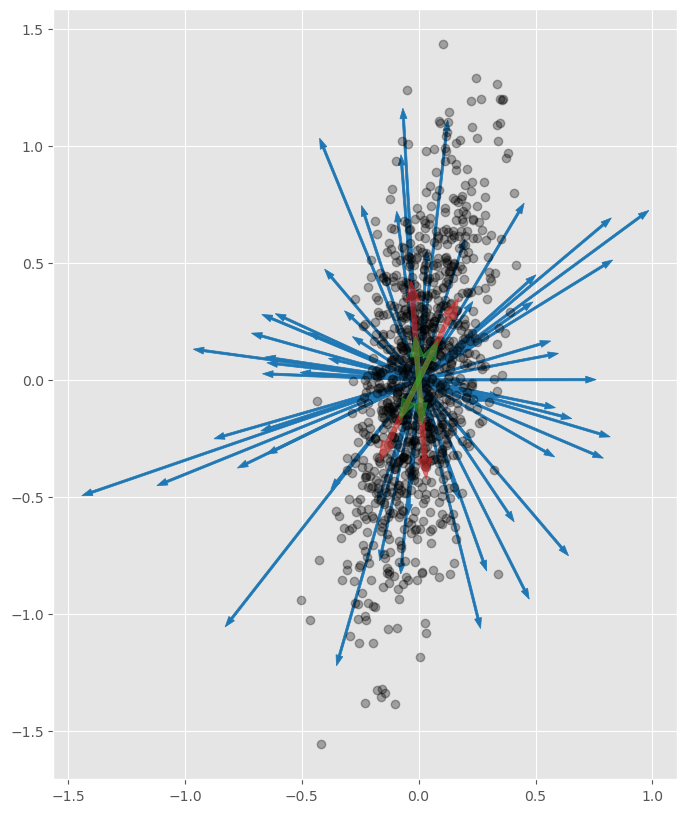

In [4]:
Xsum = Xs[0] + Xs[1]
print(Xsum.shape)
plt.imshow(Xsum)

# define a GMM model based on the covariances above
weights = [1.0, 0.0]
gmm = GaussianMixture(n_components=2)
gmm.weights_ = np.array(weights)
gmm.means_ = np.array(means)
gmm.covariances_ = np.array([Xsum, X])
plt.figure()
plt.hist(test_decoder[0])
plt.hist(test_decoder[1])

top_components = []
singular_vals = []
plt.figure()
for X in Xs: 
    U, S, V = np.linalg.svd(X)
    top_components.append(U[:,0])
    singular_vals.append(S[0])
    plt.plot(S,"o")

plt.figure(figsize=(10,10))
# sample data, project onto decoder, and plot samples
samples, components = gmm.sample(1000)
print(samples.shape)
traj = test_decoder @ samples.T
plt.plot(traj[0],traj[1],"ko",alpha=0.3)
# plot covariance eigenvectors, through the decoder
for direction in test_decoder.T:
    plt.arrow(0,0,direction[0],direction[1],color="tab:blue",width=0.01)
for sv, component in zip(singular_vals,top_components):
    evec = test_decoder @ component
    # normalize evec
    evec /= np.linalg.norm(evec)
    # scale by singular value -- really want to scale by variance?
    evec *= sv         
    plt.arrow(0,0,evec[0],evec[1],color="tab:red",width=0.02,zorder=100,alpha=0.6)
    plt.arrow(0,0,-evec[0],-evec[1],color="tab:red",width=0.02,zorder=100,alpha=0.6)

Usum, Ssum, _ = np.linalg.svd(Xsum)
for i in range(2):
    evec = test_decoder @ Usum[:,i]
    sv = Ssum[i]
    # normalize evec
    evec /= np.linalg.norm(evec)
    # scale by singular value -- really want to scale by variance?
    evec *= .1
    plt.arrow(0,0,evec[0],evec[1],color="tab:green",width=0.02,zorder=100,alpha=0.6)
    plt.arrow(0,0,-evec[0],-evec[1],color="tab:green",width=0.02,zorder=100,alpha=0.6)


# plt.ylim([-2,2])
# plt.xlim([-2,2])
plt.gca().set_aspect("equal")

The conclusion is that the low-rank covariances + non-gaussianity (approximated by GMM!) lead to the X-patterns.

This is less stark if the variance overrides the covariance, leading to more of a general gaussian blob, so you need to have greater or equal covariance compared to variance.

- rank of covariance? if covariance is more complex, activity more spread in EMG space -- same analysis as PCA...
    - or how much variance is captured by the top N components to give a continuous proxy of rank
- variance vs. covariance? diag vs. off-diag? (you can get gaussian-like shape with high variance, low covariance)
- directions of low-rank covariances ~ targets -- advantage of covariance directions?

More "channels active" means that "modes" are more likely to be aligned, "less orthogonal" (simply because nonoverlapping subspaces are "more orthogonal")
- channels active? is like the distribution of the variance? its NOT the rank...
- distribution of the variance across the diagonal? ~~is this like l1 norm? or the entropy?~~ this is like "evenness" or similarity to uniformity, or "discrepancy"... 

Procedure for peeling into this per subject:
- look at the covariance structure for different emg chunks-- what is the rank of the covariances?
- Fit GMM to all data? Should we overfit to make sure to get enough modes? Bayesian fit to infer modes?
    - intitialize from the last step to get some smoothness over trials
    - maybe do this over blocks to get all targets
- Look at distribution of mixture weights -- these should be a kind of proxy for the rank of the covariance?
- look at the subspace dimension (rank) of each gaussian, track that
- track the means of the modes?

## test linear projection of gaussian

In [33]:
test_decoder.shape

(2, 64)

In [79]:
white_gmm = GaussianMixture()
white_gmm.covariances_ = np.array([np.eye(64)])
white_gmm.means_ = np.array([np.zeros(64)])
white_gmm.weights_ = np.array([1.0])
X, C = white_gmm.sample(n_samples=8000)

In [80]:
projected_gmm = GaussianMixture()
projected_gmm.covariances_ = np.array([test_decoder @ white_gmm.covariances_[0] @ test_decoder.T])
projected_gmm.means_ = np.array([test_decoder @ white_gmm.means_[0]])
projected_gmm.weights_ = white_gmm.weights_
Y, C = projected_gmm.sample(n_samples=8000)

<Axes: >

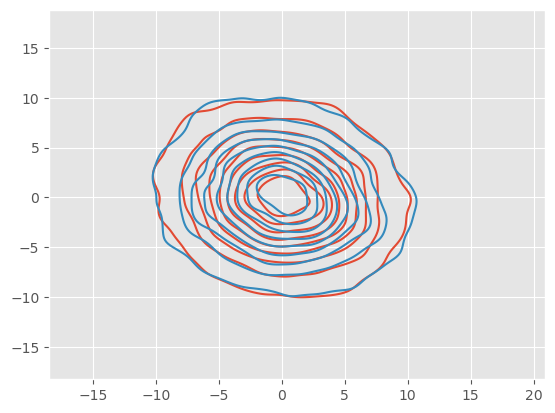

In [81]:
projected_white_samples = test_decoder @ X.T
sns.kdeplot(x=projected_white_samples[0],y=projected_white_samples[1])
sns.kdeplot(x=Y.T[0],y=Y.T[1])